# Using SNOWSLIDE in the OGGM Workflow

Ce notebook a pour objectif de guider l'utilisateur à travers l'utilisation de snowslide combiné au workflow OGGM. Il nécessite le téléchargement du package snowslide : 'https://github.com/GuillemCF/Snowslide.git'. Les informations relatives à l'utilisation de ce package sont disponibles dans le readme. Il nécessite également l'installation du modèle oggm dont les détails d'installation peuvent être retrouvés à l'adresse suivante : 'https://docs.oggm.org/en/stable/installing-oggm.html'.
Une fois installés, l'utilisateur devra se plaver dans un environnement où snowslide et oggm sont évidemment installés (ex oggm_env comme expliqué dans le tutoriel d'installation d'OGGM)

In [1]:
# Importation des librairies nécessaires à OGGM
from oggm import cfg
from oggm import tasks, utils, workflow
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
import warnings
# Some annoying warnings sometimes
warnings.filterwarnings(action='ignore', category=UserWarning)

## Pick a glacier 
On initialise le workflow et on créé un dossier qui contiendra tous les directories propres au fonctionnement d'OGGM. Modifier dir_path par le chemin d'accès au dossier où on veut que les données soient écrites. 

In [3]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='INFO')
dir_path = utils.get_temp_dir('snowslide')
# Local working directory (where OGGM will write its output)
cfg.PATHS['working_dir'] = utils.mkdir(dir_path)

2023-11-10 14:55:45: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-11-10 14:55:45: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-11-10 14:55:45: oggm.cfg: Multiprocessing: using all available processors (N=10)


On choisit les glaciers sur lesquels on veut travailler et on rendre leur index RGI dans une liste rgi_ids. Dans cet exemple on ne le fait que sur un seul glacier (mais on peut rentrer une liste de rgi_ids)

In [4]:
# rgi_ids = ['RGI60-11.01450']  # This is Aletsch
# rgi_ids = ['RGI60-11.00897']  # This is Hintereisferner
rgi_ids = ['RGI60-11.03466','RGI60-11.00897']  # This is Talefre

# This is the url with loads of data (dhdt, velocities, etc)
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/'

# Can be replaced with
# https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5
# for much less data

# This gets the data for this glacier - download can be a bit long because of all the data
gdirs = workflow.init_glacier_directories(rgi_ids, prepro_base_url=base_url, from_prepro_level=3, prepro_border=80)

2023-11-10 14:55:46: oggm.workflow: init_glacier_directories from prepro level 3 on 2 glaciers.
2023-11-10 14:55:46: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 2 glaciers


A ce stade les glacier_directories ont été créés et les données de base y sont présentes (voir dans le dossier indiqué avec dir_path). La task incluant snowslide dans OGGM a donc pour objectif de récupérer ces données, lancer une simulation snowslide et réécrire les sorties dans les glacier_directories. Aussi simple que ça !

## A task with OGGM 

On importe snowslide sous forme de task OGGM (foction associée au package python et intitulée 'oggm_snowslide_compat)


In [5]:
from snowslide import oggm_snowslide_compat

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
# run the tasks
workflow.execute_entity_task(oggm_snowslide_compat.snowslide_to_gdir, gdirs)

2023-11-10 14:55:53: oggm.workflow: Execute entity tasks [snowslide_to_gdir] on 2 glaciers
2023-11-10 14:55:53: snowslide.oggm_snowslide_compat: (RGI60-11.03466) snowslide_to_gdir
2023-11-10 14:55:55: snowslide.snowslide_main: (RGI60-11.03466) the algorithm converged in 60 iterations
2023-11-10 14:55:55: snowslide.oggm_snowslide_compat: (RGI60-11.00897) snowslide_to_gdir
2023-11-10 14:55:56: snowslide.snowslide_main: (RGI60-11.00897) the algorithm converged in 34 iterations


[None, None]

La task a été lancée et snowslide a tourné, les résultats sont enregistré dans le fichier gridded_data sous la forme 'snowslide_1m_avalanches'. On a également créé une fonction qui calcule des statistiques pour les glaciers sélectionnés avec notamment : le dépôt moyen due aux avalanches sur le glacier, l'aire de dépôt et le volume total de dépôt dues aux avalanches. Il faut noter que pour l'instant avec cette task l'utilisateur n'a pas le choix dans l'initialisation des hauteurs de neige qui se fait avec 1m de neige partout sur le dem. (il sera très facile de laisser le choix à l'utilisateur d'implémenter avec des données réelles par la suite...). Les statistiques sont accessibles avec les commandes suivantes : 

In [7]:
# run the tasks
df = oggm_snowslide_compat.compile_snowslide_statistics(gdirs)

2023-11-10 14:55:56: snowslide.oggm_snowslide_compat: Applying global task compile_snowslide_statistics on 2 glaciers
2023-11-10 14:55:56: oggm.workflow: Execute entity tasks [snowslide_statistics] on 2 glaciers
2023-11-10 14:55:56: snowslide.oggm_snowslide_compat: (RGI60-11.03466) snowslide_statistics
2023-11-10 14:55:57: snowslide.oggm_snowslide_compat: (RGI60-11.00897) snowslide_statistics


In [15]:
dfb_ava, dfb_area = oggm_snowslide_compat.compile_binned_statistics(gdirs)

2023-11-10 15:12:07: snowslide.oggm_snowslide_compat: Applying global task compile_binned_statistics on 2 glaciers
2023-11-10 15:12:07: oggm.workflow: Execute entity tasks [binned_statistics] on 2 glaciers
2023-11-10 15:12:07: snowslide.oggm_snowslide_compat: (RGI60-11.03466) binned_statistics


In [9]:
dfb_ava

,2275,2325,2375,2425,2475,2525,2575,2625,2675,2725,...,3275,3325,3375,3425,3475,3525,3575,3625,3675,3725
rgi_id,,,,,,,,,,,,,,,,,,,,,
RGI60-11.03466,0.394114,1.039966,1.004439,1.041342,1.000000,1.000000,1.0,1.00029,1.000000,1.0,...,1.471296,1.413579,1.543077,1.198108,0.859675,0.675764,0.851785,0.971889,1.000605,1.0
RGI60-11.00897,NaN,NaN,NaN,1.000000,1.073428,1.009642,1.0,1.00000,1.000744,1.0,...,0.995955,1.031912,1.056222,1.104210,0.860867,0.685184,0.681681,0.727623,0.938493,NaN


In [10]:
dfb_area.sum(axis=1) * 1e-6

rgi_id
RGI60-11.03466    7.625576
RGI60-11.00897    8.045000
dtype: float64

In [11]:
[gdir.rgi_area_km2 for gdir in gdirs]

[7.687, 8.036]

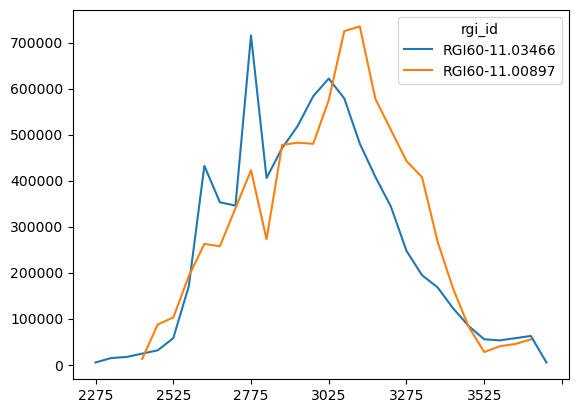

In [12]:
dfb_area.T.plot();

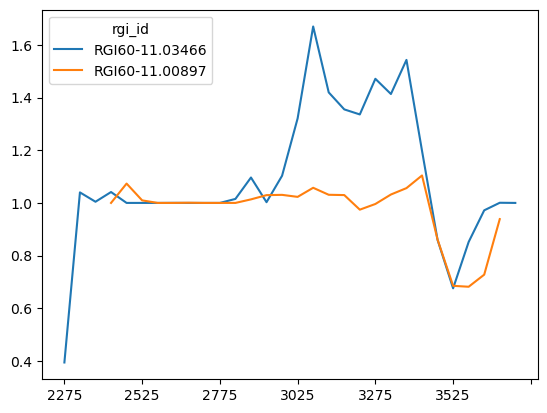

In [13]:
dfb_ava.T.plot();

In [14]:
cfg.PATHS['working_dir']

'/var/folders/29/f4w56zjd1c1b_gdh_b7bjs3c0000gq/T/OGGM/snowslide'